## Data Analysis using BulkLMM - BXD Longevity Study

In [2]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim
using Random, Distributions, LoopVectorization
using GeneNetworkAPI, Downloads
using BenchmarkTools

In [3]:
using Plots

In [4]:
local_path = "../../BulkLMM.jl/src";

In [5]:
import LossFunctions: HuberLoss, value
import Distributions: Chisq,ccdf
import StatsBase: mad, sample

function huberize(y::Vector{Float64})
    m = median(y)
    s = mad(y,normalize=true)
    z = (y.-m)./s
    l = value.(HuberLoss(1),z)
    x = sign.(z).* sqrt.(2*l)
    return m .+ s.*x
end

huberize (generic function with 1 method)

## Load processed_data:

### By individuals:

In [6]:
BXD_pheno_ind_summary_df = CSV.read("data/GN886_pheno_summary.csv", DataFrame);

By individuals, there are 248 individual samples for 32445 livear proteome.

In [7]:
println(size(BXD_pheno_ind_summary_df)) 
BXD_pheno_ind_summary_df[1:10, 1:10]

(248, 32448)


Row,Sample,Strain,Strain_num,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,11.349,11.534,17.587,17.517,17.309,16.574,16.323
2,H0370,BXD9,9,11.249,12.735,17.427,17.325,17.252,16.685,16.021
3,H2577,BXD9,9,12.415,10.487,17.89,17.488,17.594,16.731,16.208
4,H0365,BXD9,9,11.374,10.674,17.714,17.401,17.381,16.621,16.337
5,H1333,BXD13,13,11.687,11.524,17.362,17.367,17.071,16.465,15.97
6,H2259,BXD24,24,11.837,11.715,17.57,17.792,17.505,16.894,16.277
7,H1792,BXD24,24,11.563,11.434,17.789,17.847,17.416,17.042,16.292
8,H1791,BXD24,24,12.5,12.273,17.944,17.833,17.63,16.862,16.3
9,H1541,BXD24,24,11.815,11.564,17.794,17.759,17.456,16.878,16.377


In [8]:
names(BXD_pheno_ind_summary_df)[7515]

"P61924_VALRGEDVPLTEQTVSQVLQSAK_3"

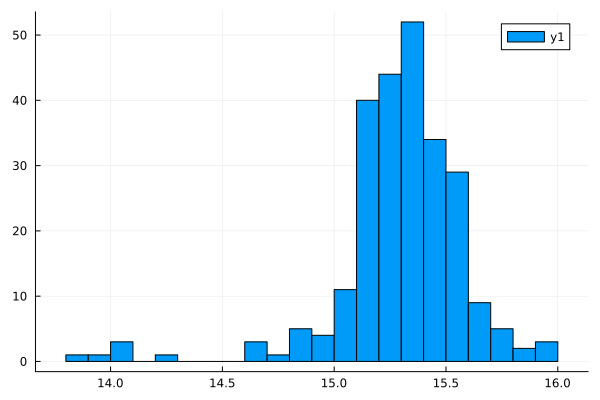

In [9]:
histogram(BXD_pheno_ind_summary_df."P61924_VALRGEDVPLTEQTVSQVLQSAK_3")

In [10]:
BXD_geno_ind_summary_df = CSV.read("data/GN886_geno_summary.csv", DataFrame);

By individuals, there are 248 individual samples for 7321 markers.

In [11]:
println(size(BXD_geno_ind_summary_df)) 
BXD_geno_ind_summary_df[1:10, 1:10]

(248, 7324)


Row,Sample,Strain,Strain_num,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,H0370,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,H2577,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,H0365,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,H1333,BXD13,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,H2259,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,H1792,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,H1791,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,H1541,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Huberized individual LPs:

In [12]:
BXD_pheno_huber_ind_summary_df = CSV.read("data/GN886_pheno_huber_summary.csv", DataFrame);

In [13]:
println(size(BXD_pheno_huber_ind_summary_df)) 
BXD_pheno_huber_ind_summary_df[1:10, 1:10]

(248, 32448)


Row,Sample,Strain,Strain_num,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,11.35,11.534,17.587,17.517,17.309,16.574,16.323
2,H0370,BXD9,9,11.2619,12.6093,17.4271,17.3294,17.252,16.685,16.0223
3,H2577,BXD9,9,12.415,10.5848,17.8852,17.488,17.5905,16.731,16.208
4,H0365,BXD9,9,11.3741,10.7134,17.714,17.401,17.381,16.621,16.337
5,H1333,BXD13,13,11.687,11.524,17.3718,17.3671,17.096,16.4699,15.9795
6,H2259,BXD24,24,11.837,11.715,17.57,17.792,17.505,16.894,16.277
7,H1792,BXD24,24,11.563,11.434,17.789,17.8432,17.416,17.0223,16.292
8,H1791,BXD24,24,12.5,12.2701,17.9262,17.8312,17.6187,16.862,16.3
9,H1541,BXD24,24,11.815,11.564,17.794,17.759,17.456,16.878,16.377


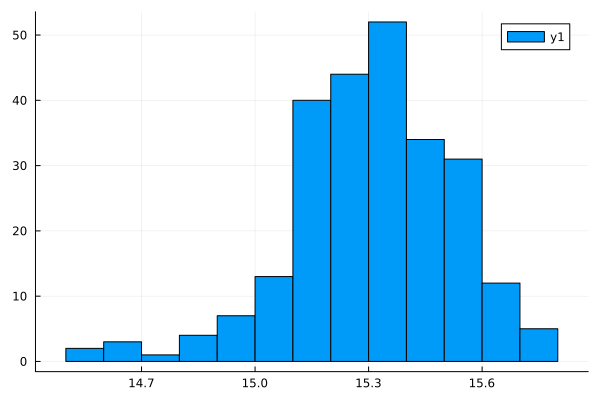

In [14]:
histogram(BXD_pheno_huber_ind_summary_df."P61924_VALRGEDVPLTEQTVSQVLQSAK_3")

### By strains:

In [15]:
BXD_pheno_strains_summary_df = CSV.read("data/GN886_pheno_strain_means_summary.csv", DataFrame);

By strains, there are 50 BXD strains for 32445 liver proteome.

In [16]:
println(size(BXD_pheno_strains_summary_df)) 
BXD_pheno_strains_summary_df[1:10, 1:10]

(50, 32447)


Row,Strain,Number of Samples,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2,Q99M02_QLQQVGTVSK_2
,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,BXD9,4,11.5968,11.3575,17.6545,17.4327,17.384,16.6528,16.2222,16.3227
2,BXD13,1,11.687,11.524,17.362,17.367,17.071,16.465,15.97,15.98
3,BXD24,5,12.0778,11.7458,17.7926,17.8152,17.5168,16.9196,16.3012,16.4304
4,BXD27,3,11.717,11.149,17.336,17.3143,17.165,16.5283,15.9407,16.002
5,BXD29,11,11.735,11.3496,17.4583,17.3877,17.2431,16.4945,16.0869,16.1075
6,BXD32,8,11.6266,11.554,17.8254,17.7716,17.4639,16.9029,16.434,16.425
7,BXD34,13,11.7491,11.9135,17.6108,17.5974,17.2988,16.7761,16.3147,16.2926
8,BXD39,5,11.9158,11.719,17.395,17.385,17.157,16.5226,16.179,16.0594
9,BXD40,8,11.8651,11.6817,17.5986,17.6386,17.3861,16.6824,16.2855,16.2523


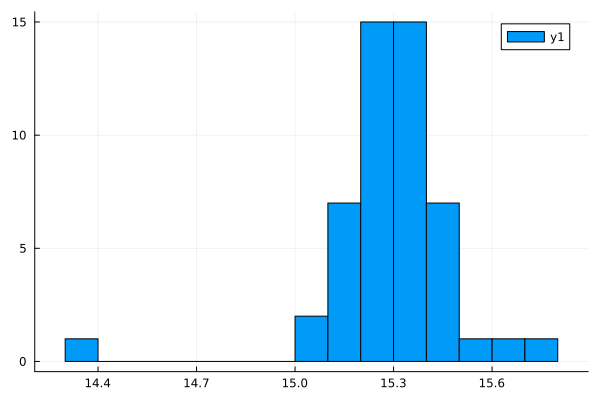

In [17]:
histogram(BXD_pheno_strains_summary_df."P61924_VALRGEDVPLTEQTVSQVLQSAK_3")

In [18]:
BXD_geno_strains_summary_df = CSV.read("data/GN886_geno_strains_summary.csv", DataFrame);

By strains, there are 50 BXD strains for 7321 markers.

In [19]:
println(size(BXD_geno_strains_summary_df)) 
BXD_geno_strains_summary_df[1:10, 1:10]

(50, 7322)


Row,Strain,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298,rs51852623,rs31879829
,String7,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,BXD9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BXD13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BXD24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BXD27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,BXD29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,BXD32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,BXD34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,BXD39,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,BXD40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Huberized strain means LPs:

In [20]:
# BXD_pheno_huber_strains_summary_df = CSV.read("data/GN886_pheno_huber_strain_means_summary.csv", DataFrame);

In [21]:
# println(size(BXD_pheno_huber_strains_summary_df)) 
# BXD_pheno_huber_strains_summary_df[1:10, 1:10]

In [22]:
# histogram(BXD_pheno_huber_strains_summary_df."P61924_VALRGEDVPLTEQTVSQVLQSAK_3")

In [23]:
# mean(BXD_pheno_huber_ind_summary_df[1:4, 4])

In [24]:
# mean(BXD_pheno_huber_ind_summary_df[11:13, 4])

## Load functions:

In [25]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));

## Objectives

- gemma one trait, ind and strains

- scan_alt one trait, ind and strains

- scan_null one trait, ind and strains

- bulkscan_grid (null), all traits, ...

- data structure for all traits results...

- Heatmap grids_taken, compare on strain means and individuals

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

- Loglikelihood by h2_grid plot, strain means v.s. individuals

- Report fixed effects:

- Adjusting difference in the number of samples across strains

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

## Run BulkLMM.jl:

### Calculate kinship:

First, calculate the kinship matrix of relatedness among the strains (50-by-50):

In [26]:
geno_strains = Matrix{Float64}(BXD_geno_strains_summary_df[:, 2:end]);

In [27]:
kinship_strains = calcKinship(geno_strains);

Then, construct the kinship matrix of relatedness among the individuals based on which strain they are from:

In [28]:
function calcRepeats(x::Array{Int64, 1})
    
    counting_dict = Dict{Int64, Int64}();
    
    for i in 1:length(x)
        curr_key = x[i];
        if haskey(counting_dict, curr_key) # if current key already exists
            counting_dict[curr_key] += 1;
        else # if current key does not present, add it as a new key
            counting_dict[curr_key] = 1;
        end
    end
    
    return counting_dict
    
end

calcRepeats (generic function with 1 method)

In [29]:
function calcIndKinship_from_StrainKinship(kinship_strains::Array{Float64, 2}, 
                                           strain_info_about_samples::Array{Int64, 1})
    
    counting_dict = calcRepeats(strain_info_about_samples);
    reps_each_strain = map(x -> counting_dict[x], unique(strain_info_about_samples));
    
    # Initialize the placeholder:
    kinship_ind_from_strains = ones(sum(reps_each_strain), sum(reps_each_strain));

    # process the first BXD strain...
    reps_strain_1 = reps_each_strain[1];
    k_11 = kinship_strains[1, 1];
    # block_11 = ones(reps_strain_1, reps_strain_1);

    row_id = 0;
    col_id = 0;

    @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                             (row_id+1):(row_id+reps_strain_1)] .*= k_11;

    for j in 2:length(reps_each_strain)
        reps_strain_j = reps_each_strain[j];
        k_1j = kinship_strains[1, j];
        # block_1j = ones(reps_strain_1, reps_strain_j);

        col_id += reps_each_strain[j-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                                 (col_id+1):(col_id+reps_strain_j)] .*= k_1j;

        # process the off-diagonal block conveniently...
        # block_j1 = ones(reps_strain_j, reps_strain_1);
        kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                 (row_id+1):(row_id+reps_strain_1)] .*= k_1j;

    end

    # process for the second BXD strain and all after...
    # for i in 2:length(reps_each_strain)
    for i in 2:length(reps_each_strain)

        reps_strain_i = reps_each_strain[i];
        k_ii = kinship_strains[i, i];
        # block_ii = ones(reps_strain_i, reps_strain_i);

        row_id += reps_each_strain[i-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                 (row_id+1):(row_id+reps_strain_i)] .*= k_ii;

        col_id = row_id+reps_strain_i;

        for j in (i+1):length(reps_each_strain)

            reps_strain_j = reps_each_strain[j];
            k_ij = kinship_strains[i, j];
            # block_ij = ones(reps_strain_i, reps_strain_j);

            @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                     (col_id+1):(col_id+reps_strain_j)] .*= k_ij;

            # process the off-diagonal block conveniently...
            # block_ji = ones(reps_strain_j, reps_strain_i);
            @views kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                     (row_id+1):(row_id+reps_strain_i)] .*= k_ij;

            col_id += reps_each_strain[j];
        end
    
    end
    
    return kinship_ind_from_strains
end

calcIndKinship_from_StrainKinship (generic function with 1 method)

In [30]:
BXD_geno_ind_summary_df.Strain_num = Vector{Int64}(BXD_geno_ind_summary_df.Strain_num);

In [31]:
@time kinship_ind_from_strains = calcIndKinship_from_StrainKinship(kinship_strains, BXD_geno_ind_summary_df.Strain_num);

  0.000257 seconds (76 allocations: 503.766 KiB)


Compare the runtime with directly calculating the kinship matrix from individual genotype data:

In [32]:
geno_ind = Matrix{Float64}(BXD_geno_ind_summary_df[:, 4:end]);

In [33]:
@time kinship_ind_from_ind = calcKinship(geno_ind);

  3.298689 seconds (306.28 k allocations: 8.368 GiB, 6.27% gc time)


In [34]:
maximum(abs.(kinship_ind_from_ind .- kinship_ind_from_strains))

0.04186586531894554

### Single-trait genome scans:

To see single trait genome scan results, we take the 7512-th livear proteomic as the single trait to run analysis:  

In [35]:
lp_names = names(BXD_pheno_ind_summary_df)[4:end];

In [36]:
lp_id = 7512;
lp_names[lp_id]

"P61924_VALRGEDVPLTEQTVSQVLQSAK_3"

#### For individual liver proteome

In [37]:
lp_ind_Y = Matrix{Float64}(BXD_pheno_ind_summary_df[:, 4:end]);
lp_ind_y = reshape(lp_ind_Y[:, lp_id], :, 1);

In [38]:
## Huberized individuals data:
lp_ind_Y_hub = Matrix{Float64}(BXD_pheno_huber_ind_summary_df[:, 4:end]);
lp_ind_y_hub = reshape(lp_ind_Y_hub[:, lp_id], :, 1);

In [39]:
lpst_ind_Y = colStandardize(lp_ind_Y);
lpst_ind_y = reshape(lpst_ind_Y[:, lp_id], :, 1);
lpst_ind_Y_hub = colStandardize(lp_ind_Y_hub);
lpst_ind_y_hub = reshape(lpst_ind_Y_hub[:, lp_id], :, 1);

In [40]:
@time scan_results_ind = scan(lp_ind_y, geno_ind, kinship_ind_from_strains);

  0.172116 seconds (80.94 k allocations: 134.905 MiB)


In [41]:
@time scan_results_ind_alt = scan(lp_ind_y, geno_ind, kinship_ind_from_strains;
                                  assumption = "alt");

  5.005654 seconds (4.00 M allocations: 4.976 GiB, 15.40% gc time)


In [42]:
@time scan_st_results_ind_alt = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                                  assumption = "alt", 
                                  prior_variance = 1.0, prior_sample_size = 0.1);

  4.201728 seconds (3.89 M allocations: 4.830 GiB, 7.62% gc time)


##### Huberized...

In [43]:
@time scan_results_ind_hub = scan(lp_ind_y_hub, geno_ind, kinship_ind_from_strains);

  0.130011 seconds (81.10 k allocations: 135.087 MiB)


In [44]:
@time scan_results_ind_alt_hub = scan(lp_ind_y_hub, geno_ind, kinship_ind_from_strains;
                                      assumption = "alt");

  7.548068 seconds (6.98 M allocations: 8.671 GiB, 7.41% gc time)


In [45]:
@time scan_st_results_ind_alt_hub = scan(lpst_ind_y_hub, geno_ind, kinship_ind_from_strains;
                                         assumption = "alt",
                                         prior_variance = 1.0, prior_sample_size = 0.1);

  7.699729 seconds (6.98 M allocations: 8.671 GiB, 7.12% gc time)


In [46]:
scan_results_ind_hub.h2_null

0.0

In [47]:
scan_results_ind_alt_hub.h2_null

0.0

In [48]:
scan_st_results_ind_alt_hub.h2_null

0.0

In [49]:
hcat(scan_results_ind_alt.lod, scan_results_ind_alt_hub.lod)

7321×2 Matrix{Float64}:
 0.232151  0.0729695
 0.232151  0.0729695
 0.232151  0.0729695
 0.232151  0.0729695
 0.232151  0.0729695
 0.232151  0.0729695
 0.232151  0.0729695
 0.232151  0.0729695
 0.232151  0.0729695
 0.232151  0.0729695
 0.232151  0.0729695
 0.232151  0.0729695
 0.224441  0.096154
 ⋮         
 0.764663  0.846453
 0.764663  0.846453
 0.764663  0.846453
 0.693795  0.744502
 0.554794  0.594852
 0.554794  0.594852
 0.593088  0.667094
 0.637187  0.715399
 0.593088  0.667094
 0.637187  0.715399
 0.510479  0.536802
 0.510479  0.536802

In [50]:
@time scan_perms_results_ind = scan(lp_ind_y, geno_ind, kinship_ind_from_strains;
                                    permutation_test = true, nperms = 1000, original = true);

  0.922270 seconds (1.91 M allocations: 259.288 MiB, 89.03% compilation time)


#### For liver proteome means by strains

In [51]:
lp_strains_Y = Matrix{Float64}(BXD_pheno_strains_summary_df[:, 3:end]);
lp_strains_y = reshape(lp_strains_Y[:, lp_id], :, 1);

In [52]:
lpst_strains_Y = colStandardize(lp_strains_Y);
lpst_strains_y = reshape(lpst_strains_Y[:, lp_id], :, 1);

(strain means of the huberized individual liver proteome...)

In [53]:
# lp_strains_Y_hub = Matrix{Float64}(BXD_pheno_huber_strains_summary_df[:, 3:end]);
# lp_strains_y_hub = reshape(lp_strains_Y_hub[:, lp_id], :, 1);

Instead, take the strain means from the original individual data, and then apply huberization:

In [54]:
@time lp_strains_Y_hub = map(x -> huberize(lp_strains_Y[:, x]), 1:size(lp_strains_Y, 2));
@time lp_strains_Y_hub = reduce(hcat, lp_strains_Y_hub);
lp_strains_y_hub = reshape(lp_strains_Y_hub[:, lp_id], :, 1);

  0.480738 seconds (1.46 M allocations: 182.745 MiB, 68.28% compilation time)
  0.048525 seconds (87.29 k allocations: 17.325 MiB, 86.47% compilation time)


In [55]:
BXD_strain_means_huberized_summary_df = DataFrame(
    hcat(Matrix{Any}(BXD_pheno_strains_summary_df[:, 1:2]), lp_strains_Y_hub),
    names(BXD_pheno_strains_summary_df));

CSV.write("data/GN886_pheno_huber_strain_means_summary.csv", BXD_strain_means_huberized_summary_df);

In [56]:
lpst_strains_Y_hub = colStandardize(lp_strains_Y_hub);
lpst_strains_y_hub = reshape(lpst_strains_Y_hub[:, lp_id], :, 1);

In [57]:
@time scan_results_strains = scan(lp_strains_y, geno_strains, kinship_strains; prior_variance = var(lp_strains_y));

  0.108344 seconds (243.46 k allocations: 41.780 MiB, 62.59% compilation time)


In [58]:
@time scan_results_strains_alt = scan(lp_strains_y, geno_strains, kinship_strains;
                                      assumption = "alt");

  4.028338 seconds (10.34 M allocations: 3.214 GiB, 11.20% gc time)


##### Huberized... 

In [59]:
@time scan_results_strains_hub = scan(lp_strains_y_hub, geno_strains, kinship_strains);

  0.044570 seconds (80.91 k allocations: 32.292 MiB)


In [60]:
@time scan_results_strains_alt_hub = scan(lp_strains_y_hub, geno_strains, kinship_strains;
                                          assumption = "alt");

  2.228895 seconds (5.79 M allocations: 1.801 GiB, 8.57% gc time)


In [61]:
@time scan_results_strains_alt_hub_c = scan(lp_strains_y_hub, geno_strains, kinship_strains;
                                          assumption = "alt",  
                                          prior_variance = var(lp_strains_y_hub), 
                                          prior_sample_size = 0.1);

  2.390328 seconds (6.01 M allocations: 1.869 GiB, 11.78% gc time, 0.20% compilation time)


In [62]:
@time scan_perms_results_strains = scan(lp_strains_y, geno_strains, kinship_strains;
                                        permutation_test = true, nperms = 1000, original = true);

  0.033696 seconds (91.31 k allocations: 79.028 MiB)


### Multiple-trait genome scans:

In [63]:
BLAS.set_num_threads(16)

In [64]:
BLAS.get_num_threads()

16

In [65]:
grid_list = collect(0.0:0.01:0.99);

#### For individual liver proteome

In [66]:
@benchmark bulkscan_null_grid(lp_ind_Y, geno_ind, kinship_ind_from_strains, grid_list)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 18.270 s (7.62% GC) to evaluate,
 with a memory estimate of 41.76 GiB, over 46806687 allocations.

In [67]:
@time bulkscan_results_null_ind = bulkscan_null(lp_ind_Y, geno_ind, kinship_ind_from_strains; nb = 16);

193.207012 seconds (2.60 G allocations: 1.814 TiB, 12.78% gc time, 0.03% compilation time)


In [68]:
BLAS.set_num_threads(16)

In [69]:
@benchmark bulkscan_alt_grid(lp_ind_Y, geno_ind, kinship_ind_from_strains, grid_list)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 118.814 s (1.26% GC) to evaluate,
 with a memory estimate of 208.84 GiB, over 43457651 allocations.

In [70]:
@time bulkscan_results_ind = bulkscan_null_grid(lp_ind_Y, geno_ind, kinship_ind_from_strains, grid_list);

 17.868354 seconds (46.81 M allocations: 41.761 GiB, 3.28% gc time)


#### For liver proteome means by strains

In [71]:
grid_list = collect(0.0:0.01:0.99);

In [72]:
@benchmark bulkscan_null_grid(lp_strains_Y, geno_strains, kinship_strains, grid_list)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 7.519 s (7.52% GC) to evaluate,
 with a memory estimate of 11.78 GiB, over 43673888 allocations.

In [73]:
@time bulkscan_results_null_strains = bulkscan_null(lp_strains_Y, geno_strains, kinship_strains);

 65.088784 seconds (2.61 G allocations: 434.646 GiB, 38.94% gc time)


In [74]:
BLAS.set_num_threads(16)

In [75]:
@benchmark bulkscan_alt_grid(lp_strains_Y, geno_strains, kinship_strains, grid_list)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 84.884 s (1.47% GC) to evaluate,
 with a memory estimate of 184.22 GiB, over 43457817 allocations.

In [76]:
@time bulkscan_results_strains = bulkscan_null_grid(lp_strains_Y, geno_strains, kinship_strains, grid_list);

  8.389346 seconds (43.67 M allocations: 11.782 GiB, 5.10% gc time)


In [77]:
scan_results_ind_hub.h2_null

0.0

In [78]:
scan_results_strains_hub.h2_null

0.0

In [83]:
hcat(scan_results_ind.lod, bulkscan_results_ind.L[:, lp_id], 
     scan_results_strains.lod, bulkscan_results_strains.L[:, lp_id]) |> 
(x -> DataFrame(x, ["LOD_ind", "LOD_ind_grid",  "LOD_strains", "LOD_strains_grid"])) |> x -> x[1:10, :]

Row,LOD_ind,LOD_ind_grid,LOD_strains,LOD_strains_grid
,Float64,Float64,Float64,Float64
1,0.232074,0.232067,0.0175979,0.0175979
2,0.232074,0.232067,0.0175979,0.0175979
3,0.232074,0.232067,0.0175979,0.0175979
4,0.232074,0.232067,0.0175979,0.0175979
5,0.232074,0.232067,0.0175979,0.0175979
6,0.232074,0.232067,0.0175979,0.0175979
7,0.232074,0.232067,0.0175979,0.0175979
8,0.232074,0.232067,0.0175979,0.0175979
9,0.232074,0.232067,0.0175979,0.0175979


In [84]:
scan_results_strains_alt.lod

7321-element Vector{Float64}:
 0.01759789271605796
 0.01759789271605796
 0.01759789271605796
 0.01759789271605796
 0.01759789271605796
 0.01759789271605796
 0.01759789271605796
 0.01759789271605796
 0.01759789271605796
 0.01759789271605796
 0.01759789271605796
 0.01759789271605796
 0.018276021885086768
 ⋮
 1.121859037927299
 1.121859037927299
 1.121859037927299
 1.0740009400657125
 0.988228626611079
 0.988228626611079
 1.0330695940989287
 1.1292342006500697
 1.0330695940989287
 1.1292342006500697
 0.8539088796289366
 0.8539088796289366

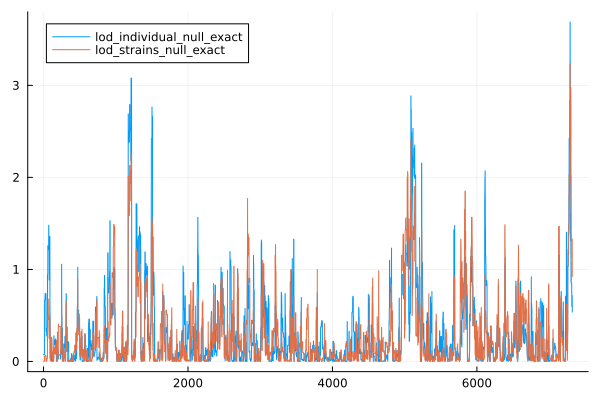

In [80]:
plot(scan_results_ind_hub.lod, label = "lod_individual_null_exact");
plot!(scan_results_strains_hub.lod, label = "lod_strains_null_exact")

In [81]:
maximum(abs.(scan_results_strains_hub.lod .- bulkscan_results_strains.L[:, lp_id]))

0.8568184216302921

In [82]:
(lp_strains_y0, X0, lambda0) = transform_rotation(lp_strains_y, geno_strains, kinship_strains);

## Run GEMMA for single-trait scans:

In [ ]:
pwd()

In [ ]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

In [ ]:
run(`$gemma -h`)

In [ ]:
function transform_bxd_pheno_to_gemma2(inputfile::AbstractString, outputfile::AbstractString, iter::Int64)
    pheno = CSV.read(inputfile, DataFrame);
    pheno = Matrix{Float64}(pheno[:, 3:end]);
    open(outputfile, "w") do io
        writedlm(io, pheno[:, iter])
    end
    return pheno
end

In [ ]:
function transform_bxd_geno_to_gemma2(inputfile::AbstractString, outputfile::AbstractString, 
                                      startCol::Int64)
    data = CSV.read(inputfile, DataFrame);
    
    marker_names = names(data)[startCol:end];
    data = 2 .* data[:, startCol:end] |> x -> Matrix{Float64}(x)
    # data = data[:, startCol:end] |> x -> Matrix{Float64}(x)
    minor_allele = fill("A", length(marker_names), 1);
    major_allele = fill("B", length(marker_names), 1);
    output = hcat(hcat(marker_names, minor_allele, major_allele), transpose(data))
    writeToFile(output, outputfile)
    return output
end

In [ ]:
lp_id

In [ ]:
transform_bxd_geno_to_gemma2("data/GN886_geno_strains_summary.csv", "data/GEMMA_data/GN886_geno_strains_summary.txt", 2);
transform_bxd_geno_to_gemma2("data/GN886_geno_summary.csv", "data/GEMMA_data/GN886_geno_ind_summary.txt", 4);

In [ ]:
transform_bxd_pheno_to_gemma2("data/GN886_pheno_huber_strain_means_summary.csv", "data/GEMMA_data/GN886_pheno_huber_strains_summary.txt", lp_id);
transform_bxd_pheno_to_gemma2("data/GN886_pheno_huber_summary.csv", "data/GEMMA_data/GN886_pheno_huber_ind_summary.txt", lp_id);

In [ ]:
writedlm("data/GEMMA_data/kinship_strains.txt", kinship_strains, '\t')
writedlm("data/GEMMA_data/kinship_ind.txt", kinship_ind_from_strains, '\t')

In [ ]:
function p2lod(pval::Float64, df::Int64)
    
    lrs = invlogcdf(Chisq(df), log(1-pval))
    lod = lrs/(2*log(10))
    
    # return lrs
    return lod

end

In [ ]:
function gemmaWrapper(pheno_filename::String, geno_filename::String,
                      kinship_filename::String, output_filename::String)
    
    run(`$gemma -g $geno_filename -p $pheno_filename -k $kinship_filename -lmm 2 -lmax 1000000 -o $output_filename`)
    
end

In [ ]:
@time gemmaWrapper("data/GEMMA_data/GN886_pheno_strains_summary.txt", 
                   "data/GEMMA_data/GN886_geno_strains_summary.txt",
                   "data/GEMMA_data/kinship_strains.txt",
                   "results_strains.txt");

In [ ]:
@time gemmaWrapper("data/GEMMA_data/GN886_pheno_huber_ind_summary.txt", 
                   "data/GEMMA_data/GN886_geno_ind_summary.txt",
                   "data/GEMMA_data/kinship_ind.txt",
                   "results_ind.txt");

In [ ]:
sum(eigen(kinship_ind_from_strains).values.<0.0001)

In [ ]:
gemma_results_strains = readdlm("output/results_strains.txt.assoc.txt", '\t');
gemma_results_ind = readdlm("output/results_ind.txt.assoc.txt", '\t');

In [ ]:
gemma_strains = gemma_results_strains[2:end, 10] |> x -> Array{Float64}(x);
gemma_ind = gemma_results_ind[2:end, 10] |> x -> Array{Float64}(x);

In [ ]:
gemma_strains_lod = p2lod.(gemma_strains, 1);
gemma_ind_lod = p2lod.(gemma_ind, 1);

In [ ]:
hcat(gemma_ind_lod, scan_results_ind.lod)

In [ ]:
hcat(gemma_strains_lod, scan_results_strains_alt_hub.lod, bulkscan_results_strains[3][:, lp_id])

In [ ]:
lookRange = 2001:4000

In [ ]:
lookRange = 1:1000

In [ ]:
plot(gemma_strains_lod[lookRange], label = "GEMMA_strains");
# plot!(scan_results_strains_alt_hub.lod[lookRange], label = "BulkLMM_strains")
plot!(bulkscan_results_strains[3][lookRange, lp_id], label = "BulkLMM_strains_grid")

In [ ]:
scan_results_ind.h2_null

## Examine loglikelihood:

In [ ]:
fitlmm(lp_strains_y0, reshape(X0[:, 1], :, 1), lambda0, [0.0, 0.0]).h2

In [ ]:
w = makeweights(0.601192247603648, lambda0);
w_h0 = makeweights(0.0, lambda0);

In [ ]:
wls(lp_strains_y0, reshape(X0[:, 1], :, 1), w, [0.0, 0.0]).ell

In [ ]:
wls(lp_strains_y0, reshape(X0[:, 1], :, 1), w_h0, [0.0, 0.0]).ell

In [ ]:
function getLL(y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}, markerID::Int64, h2::Float64; prior::Array{Float64, 1} = [0.0, 0.0])
    
    Gj = reshape(G[:, markerID], :, 1);
    (y0, X0, lambda0) = transform_rotation(y, Gj, K; addIntercept = true);
    w = makeweights(h2, lambda0);
    X0_inter = reshape(X0[:, 1], :, 1);
    
    return (ll_null = wls(y0, X0_inter, w, prior).ell, ll_markerID = wls(y0, X0, w, prior).ell)
    # return (wls(y0, X0_inter, w, prior).ell, wls(y0, X0, w, prior).ell)
end

In [ ]:
opt = optimize(x -> -getLL(lp_strains_y_hub, geno_strains, kinship_strains, 1997, x).ll_null, 0.0, 1.0)

In [ ]:
opt.minimizer

In [ ]:
opt.minimum

In [ ]:
-getLL(lp_strains_y_hub, geno_strains, kinship_strains, 1997, 0.0).ll_null

In [ ]:
opt.minimum <= -getLL(lp_strains_y_hub, geno_strains, kinship_strains, 1997, 0.0).ll_null

In [ ]:
var(lp_strains_y)

In [ ]:
ind_ll = map(x -> getLL(lp_ind_y, geno_ind, kinship_ind_from_strains, 1997, x), collect(0.0:0.001:0.999));
strains_ll = map(x -> getLL(lp_strains_y, geno_strains, kinship_strains, 1997, x), collect(0.0:0.001:0.999));

In [ ]:
ind_ell_list = zeros(999);
strains_ell_list = zeros(999);
strains_ell_list_alt = zeros(999);
for k in 1:999 
    ind_ell_list[k] = ind_ll[k].ll_null;
    strains_ell_list[k] = strains_ll[k].ll_null;
    strains_ell_list_alt[k] = strains_ll[k].ll_markerID;
end

In [ ]:
scan_results_strains_hub.h2_null

In [ ]:
getLL(lp_strains_y, geno_strains, kinship_strains, 1997, 0.6011922559652536)

In [ ]:
scan_results_strains_hub.h2_null

In [ ]:
min(1.0, 2.0)

In [ ]:
scan_results_strains_alt_hub.h2_each_marker[1997]

In [ ]:
plot(strains_ell_list, label = "null")
plot!(strains_ell_list_alt, label = "alt")

In [ ]:
plot(strains_ell_list) # covariates+marker

In [ ]:
findmax(strains_ell_list)

In [ ]:
plot(collect(1:999).*0.001, ind_ell_list, xlabel = "h2", ylabel = "loglik", label = "LP individuals", color = "blue", legend=:bottomleft)
plot!(collect(1:999).*0.001, strains_ell_list, xlabel = "h2", ylabel = "loglik", label = "LP strain means", color = "red")

In [ ]:
max_lods_ind = mapslices(x -> maximum(bulkscan_results_ind[3][:, x]))